## Load data

In [2]:
# import dependencies for loading data
from sklearn.datasets import load_files
from keras.utils import np_utils
from glob import glob
import numpy as np

Using TensorFlow backend.


In [3]:
# define function to load dataset
def load_dataset(path):
    data = load_files(path)
    x_files = np.array(data['filenames'])
    y_targets = np_utils.to_categorical(np.array(data['target']), 12)
    return x_files, y_targets

#load dataset
x_files, y_targets = load_dataset('data/train')
print('Total number of images: ', len(x_files)) #4750

#load list of categories
categories = [item[11:-1] for item in sorted(glob('data/train/*/'))]
print('List of categories: ', categories)


Total number of images:  4750
List of categories:  ['Black-grass', 'Charlock', 'Cleavers', 'Common Chickweed', 'Common wheat', 'Fat Hen', 'Loose Silky-bent', 'Maize', 'Scentless Mayweed', 'Shepherds Purse', 'Small-flowered Cranesbill', 'Sugar beet']


## Data Exploration

### 1. Categorical distribution
To check if the dataset is balanced

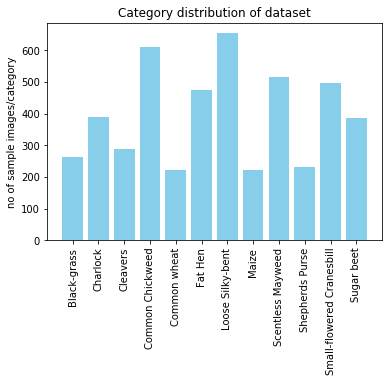

In [4]:
import matplotlib.pyplot as plt
'''
Function for displaying categorical data distribution to check if dataset is balanced
TODO: data augmentation if dataset is unbalanced
'''
category_count = np.sum(y_targets, axis = 0) # count of each class
def categorical_dist_graph(categories, count):
    fig, ax = plt.subplots()
    ax.bar(np.arange(len(categories)), count, color ='skyblue')
    ax.set_ylabel('no of sample images/category')
    ax.set_xticks(np.arange(len(categories)))
    ax.set_xticklabels(categories, rotation = 'vertical')
    ax.set_title('Category distribution of dataset')
    plt.show()

categorical_dist_graph(categories, category_count)

### 2. Display few sample images from each category

In [5]:
from collections import defaultdict
#creating dict with all categories as key, and their sample images as values

def create_dict(x_files, categories):
    category_dict = defaultdict(list)
    for category in categories:
        for i in range(len(x_files)):
            if category in x_files[i]:
                category_dict[category].append(x_files[i])
    return category_dict
category_dict = create_dict(x_files, categories)

Black-grass


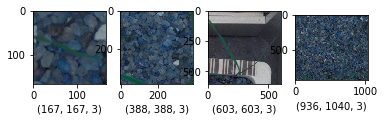

Charlock


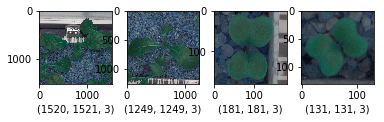

Cleavers


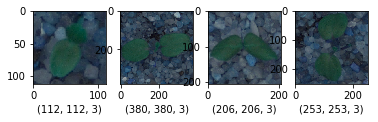

Common Chickweed


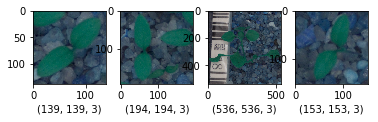

Common wheat


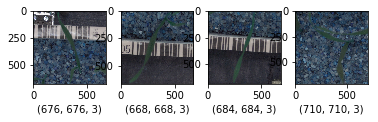

Fat Hen


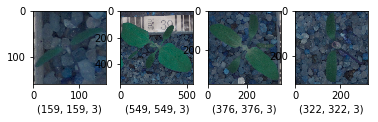

Loose Silky-bent


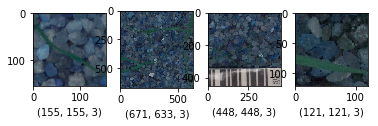

Maize


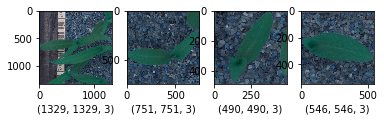

Scentless Mayweed


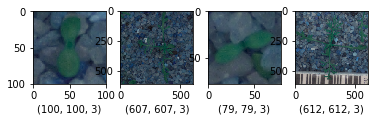

Shepherds Purse


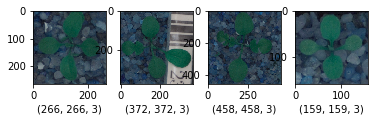

Small-flowered Cranesbill


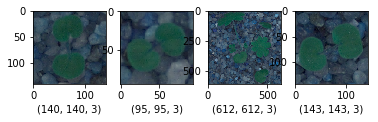

Sugar beet


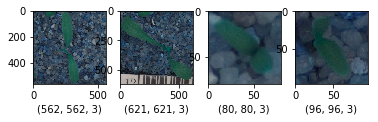

In [6]:
import random
import cv2
def show_sample(n = 3):
    '''
    displays given number of sample images from each of the categories
    '''
    for key in category_dict:
        print(key)
        fig = plt.figure()
        #fig.suptitle(key)
        for i, j in enumerate(random.sample(range(len(category_dict[key])), n)):
            img = cv2.imread(category_dict[key][j])
            fig.add_subplot(1, n, i+1)
            plt.xlabel(img.shape)
            plt.imshow(img)
        plt.show()

show_sample(4)

In [ ]:
#TODO: Mask background noise, manipulate RGB - HSV

## Train - validation split

In [9]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x_files, y_targets, test_size = 0.2, random_state=32)
print('No of images in training set: ', len(x_train))
print('No of images in validation set: ', len(x_test))

print('--------------------------------')
print('Categorical distribution of training set after train-val split: ')
train_dict = create_dict(x_train, categories)
for key in train_dict:
    print(key," : ", len(train_dict[key]))

No of images in training set:  3800
No of images in validation set:  950
--------------------------------
Categorical distribution of training set after train-val split: 
Black-grass  :  207
Charlock  :  311
Cleavers  :  224
Common Chickweed  :  487
Common wheat  :  176
Fat Hen  :  376
Loose Silky-bent  :  525
Maize  :  182
Scentless Mayweed  :  409
Shepherds Purse  :  185
Small-flowered Cranesbill  :  400
Sugar beet  :  318


### Pre-process data

#### Load train and validation set into tensors

In [10]:
from keras.preprocessing import image                  
from tqdm import tqdm

def path_to_tensor(img_path):
    ''' 
    loads RGB image as PIL.Image.Image type
    converts PIL.Image.Image type to 3D tensor with shape (224, 224, 3)
    converts 3D tensor to 4D tensor with shape (1, 224, 224, 3) and return 4D tensor
    '''
    img = image.load_img(img_path, target_size=(224, 224))
    x = image.img_to_array(img)
    return np.expand_dims(x, axis=0)

def paths_to_tensor(img_paths):
    list_of_tensors = [path_to_tensor(img_path) for img_path in tqdm(img_paths)]
    return np.vstack(list_of_tensors)

train_tensors = paths_to_tensor(x_train).astype('float32')/255
val_tensors = paths_to_tensor(x_test).astype('float32')/255

100%|██████████| 950/950 [00:12<00:00, 75.63it/s] 


In [11]:
print(train_tensors.shape)

(3800, 224, 224, 3)


## Performance Metric - F1 score
#### Defining custom metric in Keras